## **Clustering - Kmeans**

In [1]:
import sklearn as skl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

In [2]:
def set_seed(seed: int):
    random.seed(seed) # Python
    np.random.seed(seed)  # Numpy, é o gerador utilizado pelo sklearn
    os.environ["PYTHONHASHSEED"] = str(seed)  # sistema operativo

set_seed(25)

In [3]:
# Load dataset
data = pd.read_csv("../sbsppdaa24/train_radiomics_hipocamp.csv")

# Drop unique identifier columns
data.drop(columns=["Mask", "ID", "Image"], inplace=True)

# Drop non-numeric columns except for 'Transition'
columns_to_drop = [col for col in data.columns if data[col].dtype == 'object' and col != 'Transition']
data.drop(columns=columns_to_drop, inplace=True)
print(f"Dropped {len(columns_to_drop)} non-numeric columns.")

# Drop columns where all entries are the same
same_value_cols = [col for col in data.columns if data[col].nunique() == 1]
data.drop(columns=same_value_cols, inplace=True)
print(f"Dropped {len(same_value_cols)} columns with the same value for every entry.")

# Apply MinMax scaling to float columns
float_cols = data.select_dtypes(include=['float','int']).columns
scaler = MinMaxScaler()
data[float_cols] = scaler.fit_transform(data[float_cols])

# Compute correlation matrix
corr_matrix = data.drop(["Transition"],axis=1).corr().abs()

# Select upper triangle of correlation matrix to avoid duplicate pairs
upper = corr_matrix.where(~np.tril(np.ones(corr_matrix.shape)).astype(bool))

# Find features with correlation above the threshold (e.g., 0.9)
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop the highly correlated features directly from 'data'
initial_feature_count = data.shape[1]
data.drop(columns=to_drop, inplace=True)
final_feature_count = data.shape[1]

print(f"Reduced features from {initial_feature_count} to {final_feature_count}")
data.info()

Dropped 16 non-numeric columns.
Dropped 148 columns with the same value for every entry.
Reduced features from 2014 to 689
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Columns: 689 entries, diagnostics_Image-original_Mean to Transition
dtypes: float64(688), object(1)
memory usage: 1.6+ MB


In [4]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encoder = LabelEncoder()
data['Transition'] = label_encoder.fit_transform(data['Transition'])
print("Applied Label Encoding to 'Transition'.")

data.info()

Applied Label Encoding to 'Transition'.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Columns: 689 entries, diagnostics_Image-original_Mean to Transition
dtypes: float64(688), int64(1)
memory usage: 1.6 MB


In [5]:
from sklearn.cluster import KMeans

# Determinar o número ideal de clusters usando o método do cotovelo
inertia = []
range_clusters = range(1, 11)  # Avaliar de 1 a 10 clusters

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data)
    inertia.append(kmeans.inertia_)

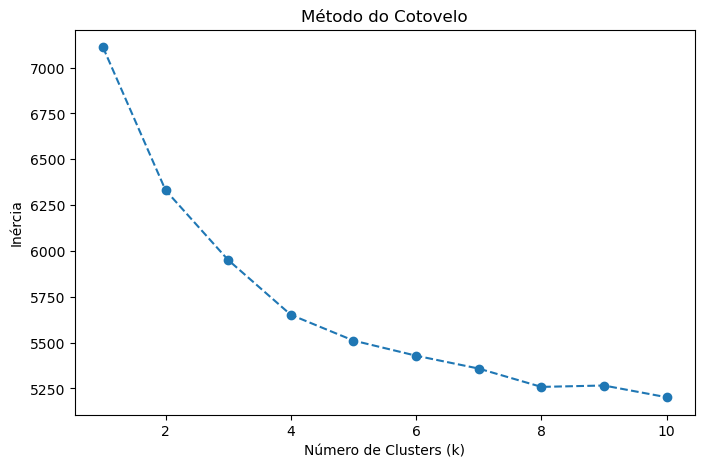

In [6]:
# Plotar o gráfico do método do cotovelo
plt.figure(figsize=(8, 5))
plt.plot(range_clusters, inertia, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo')
plt.show()

In [7]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['Cluster'] = kmeans.fit_predict(data.drop(columns=['Transition']))

# Ver os clusters atribuídos
print(data['Cluster'].value_counts())

Cluster
4    92
2    65
3    57
1    50
0    41
Name: count, dtype: int64


/tmp/ipykernel_1006/1008622902.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['Cluster'] = kmeans.fit_predict(data.drop(columns=['Transition']))


In [8]:
# Exibir os rótulos dos clusters
print("Rótulos dos clusters:")
print(data['Cluster'].value_counts())

Rótulos dos clusters:
Cluster
4    92
2    65
3    57
1    50
0    41
Name: count, dtype: int64


In [9]:
# Exibir os centros dos clusters
print("\nCentros dos clusters (coordenadas médias de cada cluster):")
print(kmeans.cluster_centers_)


Centros dos clusters (coordenadas médias de cada cluster):
[[0.58298896 0.40887267 0.59102937 ... 0.37314634 0.80487805 0.58871353]
 [0.37803466 0.24125984 0.35943874 ... 0.41538806 0.42       0.55697479]
 [0.43947191 0.21211387 0.61242563 ... 0.41608876 0.21538462 0.46377936]
 [0.36790883 0.44398398 0.34999159 ... 0.38679392 0.59649123 0.62804069]
 [0.50963461 0.44958918 0.65359492 ... 0.45390826 0.77173913 0.56345147]]


In [10]:
# Exibir uma matriz de confusão entre os rótulos verdadeiros (se conhecidos) e os clusters atribuídos
if 'Transition' in data.columns:
    true_labels = data['Transition']
    pred_labels = data['Cluster']
    print("Classification Report (baseado em clusters como predição):")
    print(classification_report(true_labels, pred_labels))
else:
    print("Nenhuma coluna de rótulo verdadeiro ('Transition') encontrada para calcular o relatório de classificação.")


Classification Report (baseado em clusters como predição):
              precision    recall  f1-score   support

           0       0.27      0.18      0.22        60
           1       0.08      0.04      0.05        96
           2       0.00      0.00      0.00        10
           3       0.35      0.29      0.32        68
           4       0.25      0.32      0.28        71

    accuracy                           0.19       305
   macro avg       0.19      0.17      0.17       305
weighted avg       0.21      0.19      0.20       305



In [11]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(data.drop(columns=['Cluster']), data['Cluster'])
print(f"Média do índice de silhueta: {silhouette_avg:.2f}")

Média do índice de silhueta: 0.04


In [12]:
cluster_summary = data.groupby('Cluster').mean()
print(cluster_summary)

         diagnostics_Image-original_Mean  diagnostics_Image-original_Maximum  \
Cluster                                                                        
0                               0.582989                            0.408873   
1                               0.378035                            0.241260   
2                               0.439472                            0.212114   
3                               0.367909                            0.443984   
4                               0.509635                            0.449589   

         diagnostics_Mask-original_VoxelNum  original_shape_Elongation  \
Cluster                                                                  
0                                  0.591029                   0.488847   
1                                  0.359439                   0.496966   
2                                  0.612426                   0.550307   
3                                  0.349992                   0.50920

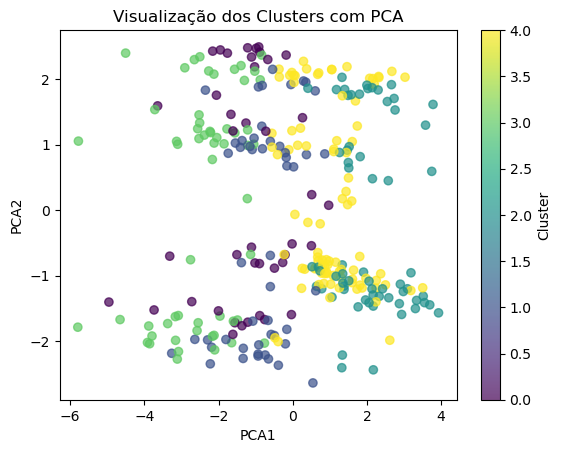

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data.drop(columns=['Cluster']))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=data['Cluster'], cmap='viridis', alpha=0.7)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Visualização dos Clusters com PCA')
plt.colorbar(label='Cluster')
plt.show()